In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# create and evaluate an updated autoregressive model
from tqdm import tqdm_notebook
import os
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from scipy.signal import savgol_filter
# load dataset
csv_dir = "/content/drive/My Drive/CS4602/assignment1/csv/"
splittedByCountry_dir  = csv_dir + "splittedByCountry/"
predictedResultAutoReg_dir = csv_dir + "predictedResultAutoReg/"

# **Finding Best Window Size for each file**

In [5]:
window_size = {}

for file in tqdm_notebook(os.listdir(splittedByCountry_dir)): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "Cases_on_an_international_conveyance_Japan.csv":
        continue
    series = read_csv(splittedByCountry_dir + file, header=0, index_col=0, parse_dates=True, squeeze=True)[['cases']]
    series = series['20200701':]

    # split dataset
    X = series.values
    X = X.flatten()
    X = savgol_filter(X, 51, 3).reshape(-1, 1)
    train, test = X[1:len(X)-7], X[len(X)-7:]

    rmse = 10*10
    window_size[file] = 40

    for window in range(5, 40):
        # train autoregression
        model = AutoReg(train, lags=window, old_names=False)
        model_fit = model.fit()
        coef = model_fit.params
        # walk forward over time steps in test
        history = train[len(train)-window:]
        history = [history[i] for i in range(len(history))]
        predictions = list()
        for t in range(len(test)):
            length = len(history)
            lag = [history[i] for i in range(length-window,length)]
            yhat = coef[0]
            for d in range(window):
                yhat += coef[d+1] * lag[window-d-1]
            obs = test[t]
            predictions.append(yhat)
            history.append(yhat)

        if rmse > sqrt(mean_squared_error(test, predictions)):
            rmse = sqrt(mean_squared_error(test, predictions))
            window_size[file] = window

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


# **Testing Model**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


Test MAPE: 31.059


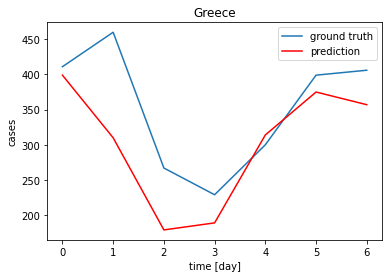

Test MAPE: 29.797


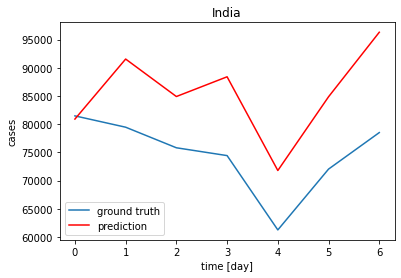

Test MAPE: 23.288


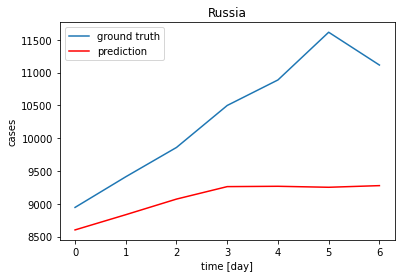

Test MAPE: 18.154


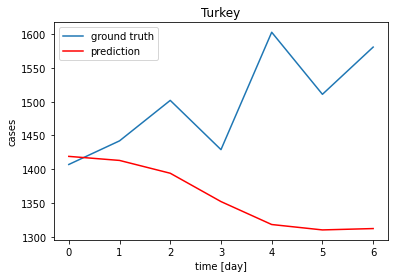

Test MAPE: 23.280


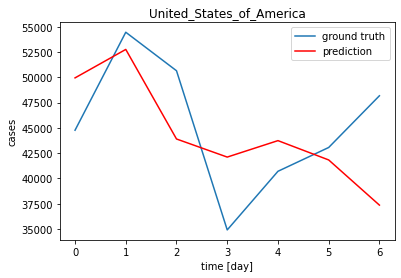

In [21]:
for file in tqdm_notebook(os.listdir(splittedByCountry_dir)): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "Cases_on_an_international_conveyance_Japan.csv":
        continue

    if file[:-4] not in ['Russia', 'Greece', 'India', 'United_States_of_America', 'Turkey']:
        continue

    series = read_csv(splittedByCountry_dir + file, header=0, index_col=0, parse_dates=True, squeeze=True)[['cases']]

    # split dataset
    X = series.values
    train, test = X[1:len(X)-7], X[len(X)-7:]

    window = window_size[file]
    # train autoregression
    model = AutoReg(train, lags=window, old_names=False)
    model_fit = model.fit()
    coef = model_fit.params
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(yhat)
        # print('predicted=%f, expected=%f' % (yhat, obs))

    ReLU = lambda a: (a > 0) * a
    predictions = np.asarray(predictions)
    predictions = ReLU(predictions)
    predictions = np.rint(predictions)
    predictions = np.abs(predictions)

    MAPE = lambda a, f: 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a))*100)


    rmse = sqrt(mean_squared_error(test, predictions))
    mape = MAPE(test, predictions)

    print('Test MAPE: %.3f' % mape)

    # plot
    pyplot.plot(test)
    pyplot.plot(predictions, color='red')
    pyplot.title(file[:-4])
    pyplot.xlabel('time [day]')
    pyplot.ylabel('cases')
    pyplot.legend(['ground truth', 'prediction'])
    pyplot.show()

# **Predicting Future Seven Days**

In [ ]:
outputs = {}

for file in tqdm_notebook(os.listdir(splittedByCountry_dir)): 
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "Cases_on_an_international_conveyance_Japan.csv":
        continue
    series = read_csv(splittedByCountry_dir + file, header=0, index_col=0, parse_dates=True, squeeze=True)[['cases']]

    # split dataset
    X = series.values

    window = window_size[file]
    # train autoregression
    model = AutoReg(X, lags=window, old_names=False)
    model_fit = model.fit()
    coef = model_fit.params
    # walk forward over time steps in test
    history = X[len(X)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(7):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(yhat)

    ReLU = lambda a: (a > 0) * a
    predictions = np.asarray(predictions)
    predictions = ReLU(predictions)
    predictions = np.rint(predictions)
    predictions = np.abs(predictions)

    outputs[file[:-4]] = predictions.flatten()
    # plot
    # pyplot.plot(predictions, color='red')
    # pyplot.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df = pd.DataFrame(data=outputs)
df['Cases_on_an_international_conveyance_Japan'] = [0, 0, 0, 0, 0, 0, 0]
df = df.reindex(sorted(df.columns), axis=1)
df.index = ['10/9', '10/10', '10/11', '10/12', '10/13', '10/14', '10/15'] 
df.to_csv(predictedResultAutoReg_dir + 'prediction.csv')
print(df)

       Afghanistan  Albania  Algeria  ...  Yemen  Zambia  Zimbabwe
10/9          55.0    158.0    124.0  ...    4.0    52.0      15.0
10/10         98.0    159.0    121.0  ...    4.0    67.0      15.0
10/11        118.0    158.0    118.0  ...    5.0    71.0      14.0
10/12         79.0    158.0    115.0  ...    3.0    79.0      21.0
10/13         84.0    159.0    113.0  ...    6.0    66.0      18.0
10/14        104.0    159.0    111.0  ...    7.0    67.0      20.0
10/15         92.0    160.0    110.0  ...    5.0    73.0      18.0

[7 rows x 210 columns]


# **Appendix**

### Printing Window Size of Each file

In [ ]:
print(len(window_size))
for key in window_size:
    print("'"+key+"'", ":", str(window_size[key])+",")

209
'Afghanistan.csv' : 36,
'Angola.csv' : 6,
'Aruba.csv' : 12,
'Albania.csv' : 5,
'Antigua_and_Barbuda.csv' : 5,
'Andorra.csv' : 9,
'Anguilla.csv' : 5,
'Australia.csv' : 12,
'Argentina.csv' : 32,
'Algeria.csv' : 23,
'Armenia.csv' : 17,
'Austria.csv' : 22,
'Azerbaijan.csv' : 37,
'Bahamas.csv' : 10,
'Bangladesh.csv' : 7,
'Bahrain.csv' : 37,
'Belarus.csv' : 14,
'Barbados.csv' : 11,
'Belgium.csv' : 22,
'Belize.csv' : 38,
'Benin.csv' : 5,
'Bermuda.csv' : 38,
'Bolivia.csv' : 32,
'Bhutan.csv' : 29,
'Bosnia_and_Herzegovina.csv' : 8,
'Bonaire, Saint Eustatius and Saba.csv' : 15,
'Botswana.csv' : 26,
'British_Virgin_Islands.csv' : 31,
'Brazil.csv' : 13,
'Bulgaria.csv' : 28,
'Brunei_Darussalam.csv' : 39,
'Burkina_Faso.csv' : 25,
'Cambodia.csv' : 31,
'Burundi.csv' : 39,
'Canada.csv' : 20,
'Cape_Verde.csv' : 37,
'Cameroon.csv' : 35,
'Cayman_Islands.csv' : 6,
'Central_African_Republic.csv' : 6,
'Chad.csv' : 27,
'Chile.csv' : 32,
'China.csv' : 23,
'Colombia.csv' : 5,
'Comoros.csv' : 16,
'Congo.csv' 

### Window Size

In [ ]:
window_size = {
'Afghanistan.csv' : 6,
'Albania.csv' : 5,
'Algeria.csv' : 25,
'Andorra.csv' : 38,
'Angola.csv' : 5,
'Anguilla.csv' : 7,
'Antigua_and_Barbuda.csv' : 29,
'Argentina.csv' : 51,
'Armenia.csv' : 48,
'Aruba.csv' : 7,
'Australia.csv' : 39,
'Austria.csv' : 51,
'Azerbaijan.csv' : 48,
'Bahamas.csv' : 13,
'Bahrain.csv' : 51,
'Bangladesh.csv' : 51,
'Barbados.csv' : 40,
'Belarus.csv' : 14,
'Belgium.csv' : 51,
'Belize.csv' : 5,
'Benin.csv' : 7,
'Bermuda.csv' : 34,
'Bhutan.csv' : 10,
'Bolivia.csv' : 51,
'Bonaire, Saint Eustatius and Saba.csv' : 8,
'Bosnia_and_Herzegovina.csv' : 51,
'Botswana.csv' : 51,
'Brazil.csv' : 51,
'British_Virgin_Islands.csv' : 6,
'Brunei_Darussalam.csv' : 16,
'Bulgaria.csv' : 8,
'Burundi.csv' : 46,
'Burkina_Faso.csv' : 7,
'Cambodia.csv' : 9,
'Cameroon.csv' : 7,
'Canada.csv' : 51,
'Cape_Verde.csv' : 23,
'Cayman_Islands.csv' : 11,
'Central_African_Republic.csv' : 8,
'Chad.csv' : 6,
'Chile.csv' : 51,
'China.csv' : 46,
'Colombia.csv' : 51,
'Congo.csv' : 10,
'Comoros.csv' : 36,
'Costa_Rica.csv' : 51,
'Cote_dIvoire.csv' : 14,
'Croatia.csv' : 9,
'Cuba.csv' : 14,
'Curaçao.csv' : 5,
'Cyprus.csv' : 20,
'Czechia.csv' : 51,
'Democratic_Republic_of_the_Congo.csv' : 12,
'Denmark.csv' : 51,
'Djibouti.csv' : 35,
'Dominica.csv' : 9,
'Dominican_Republic.csv' : 51,
'Ecuador.csv' : 51,
'Egypt.csv' : 11,
'El_Salvador.csv' : 51,
'Equatorial_Guinea.csv' : 5,
'Eritrea.csv' : 10,
'Eswatini.csv' : 6,
'Ethiopia.csv' : 51,
'Faroe_Islands.csv' : 5,
'Falkland_Islands_(Malvinas).csv' : 22,
'Estonia.csv' : 9,
'Fiji.csv' : 32,
'Finland.csv' : 50,
'France.csv' : 51,
'French_Polynesia.csv' : 5,
'Gabon.csv' : 11,
'Gambia.csv' : 17,
'Georgia.csv' : 51,
'Germany.csv' : 51,
'Ghana.csv' : 14,
'Gibraltar.csv' : 5,
'Greece.csv' : 6,
'Greenland.csv' : 13,
'Grenada.csv' : 27,
'Guam.csv' : 20,
'Guatemala.csv' : 51,
'Guernsey.csv' : 13,
'Guinea.csv' : 8,
'Guinea_Bissau.csv' : 40,
'Guyana.csv' : 17,
'Haiti.csv' : 12,
'Holy_See.csv' : 48,
'Honduras.csv' : 51,
'Hungary.csv' : 51,
'Iran.csv' : 51,
'Iceland.csv' : 5,
'India.csv' : 51,
'Indonesia.csv' : 51,
'Iraq.csv' : 51,
'Ireland.csv' : 18,
'Isle_of_Man.csv' : 33,
'Israel.csv' : 51,
'Italy.csv' : 9,
'Jamaica.csv' : 16,
'Japan.csv' : 51,
'Jersey.csv' : 32,
'Jordan.csv' : 51,
'Kazakhstan.csv' : 46,
'Kenya.csv' : 21,
'Kosovo.csv' : 41,
'Kuwait.csv' : 51,
'Kyrgyzstan.csv' : 15,
'Laos.csv' : 21,
'Latvia.csv' : 5,
'Lebanon.csv' : 51,
'Lesotho.csv' : 5,
'Liberia.csv' : 5,
'Madagascar.csv' : 14,
'Libya.csv' : 51,
'Luxembourg.csv' : 5,
'Liechtenstein.csv' : 48,
'Lithuania.csv' : 25,
'Malawi.csv' : 12,
'Malaysia.csv' : 11,
'Maldives.csv' : 5,
'Mali.csv' : 8,
'Malta.csv' : 45,
'Mauritania.csv' : 6,
'Mauritius.csv' : 33,
'Mexico.csv' : 51,
'Moldova.csv' : 51,
'Monaco.csv' : 23,
'Mongolia.csv' : 13,
'Montenegro.csv' : 51,
'Montserrat.csv' : 15,
'Morocco.csv' : 51,
'Mozambique.csv' : 5,
'Myanmar.csv' : 51,
'Namibia.csv' : 7,
'Nepal.csv' : 51,
'Netherlands.csv' : 51,
'New_Caledonia.csv' : 35,
'New_Zealand.csv' : 45,
'Nicaragua.csv' : 6,
'Niger.csv' : 31,
'Nigeria.csv' : 13,
'North_Macedonia.csv' : 15,
'Northern_Mariana_Islands.csv' : 35,
'Norway.csv' : 46,
'Oman.csv' : 51,
'Pakistan.csv' : 51,
'Palestine.csv' : 51,
'Panama.csv' : 22,
'Papua_New_Guinea.csv' : 13,
'Paraguay.csv' : 51,
'Peru.csv' : 51,
'Philippines.csv' : 51,
'Poland.csv' : 51,
'Portugal.csv' : 51,
'Puerto_Rico.csv' : 51,
'Qatar.csv' : 9,
'Romania.csv' : 51,
'Russia.csv' : 51,
'Rwanda.csv' : 9,
'Saint_Kitts_and_Nevis.csv' : 49,
'Saint_Lucia.csv' : 15,
'Saint_Vincent_and_the_Grenadines.csv' : 11,
'San_Marino.csv' : 9,
'Sao_Tome_and_Principe.csv' : 48,
'Saudi_Arabia.csv' : 9,
'Senegal.csv' : 5,
'Serbia.csv' : 35,
'Seychelles.csv' : 15,
'Sierra_Leone.csv' : 7,
'Somalia.csv' : 11,
'Singapore.csv' : 5,
'Sint_Maarten.csv' : 21,
'Slovenia.csv' : 16,
'Slovakia.csv' : 51,
'South_Africa.csv' : 51,
'South_Korea.csv' : 32,
'South_Sudan.csv' : 13,
'Spain.csv' : 51,
'Sri_Lanka.csv' : 32,
'Sudan.csv' : 12,
'Suriname.csv' : 12,
'Sweden.csv' : 19,
'Switzerland.csv' : 51,
'Taiwan.csv' : 6,
'Syria.csv' : 13,
'Tajikistan.csv' : 21,
'Thailand.csv' : 5,
'Timor_Leste.csv' : 27,
'Togo.csv' : 45,
'Tunisia.csv' : 51,
'Trinidad_and_Tobago.csv' : 6,
'Turkey.csv' : 48,
'Turks_and_Caicos_islands.csv' : 9,
'Uganda.csv' : 42,
'Ukraine.csv' : 51,
'United_Arab_Emirates.csv' : 51,
'United_Kingdom.csv' : 51,
'United_Republic_of_Tanzania.csv' : 48,
'Uruguay.csv' : 37,
'United_States_Virgin_Islands.csv' : 5,
'Uzbekistan.csv' : 51,
'United_States_of_America.csv' : 51,
'Venezuela.csv' : 51,
'Vietnam.csv' : 6,
'Western_Sahara.csv' : 13,
'Yemen.csv' : 11,
'Zambia.csv' : 17,
'Zimbabwe.csv' : 8
}